# Heatmap
### _Sample production notebook_
---
This notebook is intended to quickly produce heatmaps by utilizing parallel computation with dask. It will create intermediate files and requires a `data` directory to be in your current working directory.

#### Inputs
1. In your `data` directory, you will need a weights file. The weights file used in this sample is a `.csv` so it is loaded into a dictionary using pandas. This may need to be adjusted depending on your weights file. See below under `Get weights`. This weights dictionary is of the format: `{run_id: weight}`
2. A list of your WSE grids from s3. Only the first 100 were used in this example - `[:100]`

#### Outputs
1. `data/bool_hdf` directory: A directory containing intermediate boolean hdf files.
2. `data/weighted_chunks` directory: A directory containing hdf files of summed up weights by chunks. The number of files here will match the number of workers that were automatically set for your local cluster.
3. `data/results` directory: The output heatmap, and a clipped version _(only if your machine had enough memory to clip no data out of the raster)_.

## Import modules and define functions

In [1]:
# standard stack
import os
from time import time
from glob import glob
import sys;sys.path.append('../')

# dask
import dask
from dask.distributed import Client, LocalCluster
import dask.bag as db

# hecrasio core
from hecrasio.heatmap import *

%matplotlib inline

## Start the overall timer

In [2]:
overall_start = time()

## Set Parameters

In [3]:
bool_dir = 'data\\bool_hdfs'
weighted_dir = 'data\\weighted_chunks'
heatmap_dir = 'data\\results'
outputTifname = 'Augusta_heatmap.tif'
weights_path = 'data\\Pluvial_weights_Dewberry.csv'
heatmap_meta = {'this is...':'fake metadata!!!'}

## Get weights

In [4]:
import pandas as pd
weights_df = pd.read_csv(weights_path)
weights_df['Run_id'] = weights_df['Run'].apply(lambda x: x.split('_')[1])
weights_dict = dict(zip(weights_df['Run_id'].tolist(), weights_df['Weight'].tolist()))

## Get a list of the WSE grids

In [5]:
wse_grids = s3List("probmodelingrepository", "Augusta-Levee-AOP", "WSE_Pluvial", ".tif")[:100]
len(wse_grids)

100

### Specify the number of necessary chunks based on the estimated size of the in-memory arrays

In [6]:
num_chunks, num_workers = get_num_chunks_local(wse_grids[0])

Opening this raster will equate to roughly 0.72 GB in memory.
Using 10 for the number of chunks.
Using 20 for the number of workers.


## Set up the cluster

In [7]:
cluster = LocalCluster(n_workers=num_workers)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:49247 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 20 Cores: 20 Memory: 34.21 GB


## Use dask to make boolean hdf files

In [8]:
daskb = db.from_sequence(wse_grids)
res = daskb.map(daskbag_bool_wse_hdf_local, bool_dir=bool_dir, num_chunks=num_chunks)
res

dask.bag<daskbag..., npartitions=100>

In [9]:
st = time()

res.compute()

print(round((time() - st)/60, 2), 'minutes to run')

3.2 minutes to run


## Use dask to create a weighted grid hdf file for each chunk

In [10]:
chunkbag = db.from_sequence(range(num_chunks))

res2 = chunkbag.map(write_weighted_chunks_local, 
                    weights_dict=weights_dict,
                    bool_dir=bool_dir,
                    weighted_dir=weighted_dir
                   )
res2

dask.bag<write_w..., npartitions=10>

In [11]:
st = time()

res2.compute()

print(round((time() - st)/60, 2), 'minutes to run')

1.15 minutes to run


## Create a heatmap for the whole area
### List and sort the weighted chunks files that are local

In [12]:
weighted_hdfs = glob(os.path.join(weighted_dir, '*.hdf'))
list.sort(weighted_hdfs, key=lambda x: int(os.path.basename(x).split('_')[1]))
len(weighted_hdfs)

10

### Download one of the WSE grids to use as a template

In [13]:
tifTemplate = get_s3template_tif(wse_grids)
print(tifTemplate)

WSE_Pluvial_E001.tif


## Create the actual heatmap from the weighted chunks

In [14]:
st = time()

writeTifByChunks_local(tifTemplate, outputTifname, weighted_hdfs, heatmap_dir)
result = os.path.join(heatmap_dir, outputTifname)
update_tif_metadata(result, heatmap_meta)

print(round((time() - st)/60, 2), 'minutes to run')

data\results\Augusta_heatmap.tif has been written!
0.17 minutes to run


## Clip the raster to only include areas with data

In [15]:
if enough_mem_to_clip(result):
    crop_path = result.replace('.tif', '_clip.tif')
    clip_off_nodatas(result, crop_path)

## Plot the result

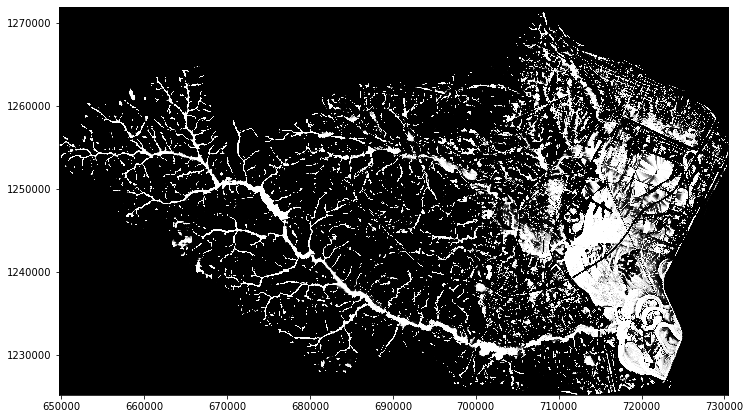

In [16]:
from rasterio.plot import show
from matplotlib import pyplot

try:
    if enough_mem_to_clip(result):
        with rasterio.open(crop_path) as ras:
            fig, ax = pyplot.subplots(1, figsize=(12, 12))
            show((ras, 1), cmap='Greys_r')
    else:
        with rasterio.open(result) as ras:
            fig, ax = pyplot.subplots(1, figsize=(12, 12))
            show((ras, 1), cmap='Greys_r')
except MemoryError:
    print('The raster is too big to plot!')

## End the timer

In [17]:
os.remove(tifTemplate)
print(round((time() - overall_start)/60, 2), 'minutes to run')

5.1 minutes to run
